In [13]:
# 7/22/21: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

# end cite


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import json
import os
from os.path import join, exists

import matplotlib.pyplot as plt

In [ ]:
from utils import load_models, transformers_bert_completions
import config

In [16]:
import importlib
importlib.reload(load_models)

<module 'utils.load_models' from '/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/utils/load_models.py'>

## Training process

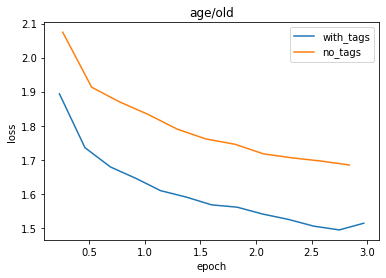

In [36]:
# Can read the results of models via trainer_state.json! 

# Intent is to figure out what is wrong with the tags fitting
# and why tags is worse -- is it overfitting?

# Also,
# Is model improving? What if we ran it for longer?
# What is happening to the loss

# Look at tags first

for arg_set in [('age', 'old')]: #config.childes_model_args: # add children later
    
    for tags in [True, False]:
        model_path = load_models.get_model_path(arg_set[0], arg_set[1], tags)
        with open(join(model_path, 'trainer_state.json'), 'r') as f:
            this_history = json.load(f)['log_history']
            
            epochs = []; losses = []
            
            for step_dict in this_history[:-1]: # Omit summary stats
                epochs.append(step_dict['epoch'])
                losses.append(step_dict['loss'])
            
            tag_str =  "with_tags" if tags else "no_tags"
            dataset_name = '/'.join(arg_set)
            
            plt.title(f'{dataset_name}')
            plt.xlabel('epoch'); plt.ylabel('loss')
            plt.plot(epochs, losses, label = tag_str)
            
    plt.legend(); plt.show()

## Tag completions

In [39]:
## Building code in advance

def analyze_completions(sentences, model, tokenizer, softmax_mask):
    
    sentence_results = {}
    
    for sentence_type, sentence in sentences.items():
        _, completions = transformers_bert_completions.bert_completions(sentence, model, tokenizer, softmax_mask)
        sentence_results[sentence_type] = completions.head(10)
        
    return sentence_results
    
chi_sentence = "[CHI] I want to [MASK]."
cgv_sentence = "[CGV] I want to [MASK]."

pred_chi = "[MASK] I want to go to the zoo."
pred_cgv = "[MASK] I want to go to the store."

sentences = {
    'chi_complete' : chi_sentence,
    'cgv_complete' : cgv_sentence,
    'pred_chi' : pred_chi,
    'pred_cgv' : pred_cgv,
}


In [22]:
tag_model.keys()

dict_keys(['title', 'kwargs', 'type'])

In [34]:
# For future use
split = 'age'; dataset = 'old'
tag_model = load_models.get_finetune_dict(split, dataset, True, 20)['kwargs']['modelLM']


initial_tokenizer = load_models.get_primary_tokenizer()

cmu_2syl_inchildes = load_models.get_cmu_dict_info()
    
initial_vocab_mask, _ = transformers_bert_completions.get_softmax_mask(initial_tokenizer,
    cmu_2syl_inchildes.word)


analysis_args = {
    'model' : tag_model,
    'tokenizer' : initial_tokenizer,
    'softmax_mask' : initial_vocab_mask,
}

In [41]:
from pprint import pprint

pprint(sentences)

{'cgv_complete': '[CGV] I want to [MASK].',
 'chi_complete': '[CHI] I want to [MASK].',
 'pred_cgv': '[MASK] I want to go to the store.',
 'pred_chi': '[MASK] I want to go to the zoo.'}


In [38]:
results = analyze_completions(sentences = sentences, **analysis_args)

print(results)

# Index out of range of self? Why?
# Because the adult model is not adjusted to the ? What tokenizer is typically used?
# It's because of the UNKs probably it (xxx, yyy) should be converted to UNK. 
# Is this expected behavior?

# How is this typically handled -- Adult BERT never receives tags so this is expected.



{'chi_complete':           prob   word  rank
180   0.173608     go     0
327   0.100470   play     1
163   0.038869    see     2
102   0.036812     do     3
1649  0.028800    eat     4
740   0.018036   stay     5
250   0.016975   come     6
380   0.013301    run     7
636   0.013030   talk     8
50    0.012445     be     9
130   0.012412   know    10
1549  0.011798  write    11
145   0.011588    get    12
265   0.011563   look    13
1821  0.010335    fly    14
1422  0.010095    sit    15
722   0.009409   hear    16
2747  0.009386  paint    17
863   0.009383   read    18
314   0.009225    say    19, 'cgv_complete':           prob   word  rank
180   0.246888     go     0
163   0.057605    see     1
1649  0.045923    eat     2
636   0.038643   talk     3
130   0.035299   know     4
327   0.033464   play     5
250   0.030008   come     6
722   0.026493   hear     7
740   0.025348   stay     8
314   0.022044    say     9
1549  0.018772  write    10
2091  0.016107    cry    11
102   0.015896